In [ ]:
# IMPORTS
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.fft import irfft, rfft, rfftfreq
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
from scipy.signal import welch, get_window
import os


from funcs_dsp import *
from funcs_df import load_df

In [ ]:
# Load dataframe(s) and concatenate (with laptop=False and no dfs_to_load this loads all dataframes with OSC paths)
laptop = True
dfs_to_load = ["UWO Data"]
df_UWO = load_df(laptop=laptop, dfs_to_load=dfs_to_load)
df = df_UWO[df_UWO['wf'].notna()]

f = rfftfreq(32768, 1/44100)

index = 10
wf = df.iloc[index]['wf']
sr = 44100

In [ ]:
"SMS vs PSD"
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal

rng = np.random.default_rng(73625)  # seeding for reproducibility

fs, n = 10e3, 10_000
f_x, noise_power = 1270, 1e-3 * fs / 2
t = np.arange(n) / fs
x = (np.sqrt(2) * np.sin(2 * np.pi * f_x * t) +
     rng.normal(scale=np.sqrt(noise_power), size=t.shape))

fg, axx = plt.subplots(1, 2, sharex='all', tight_layout=True, figsize=(7, 3.5))
axx[0].set(title="Squared Magnitude Spectrum", ylabel="Square of Magnitude in V²")
axx[1].set(title="Power Spectral Density", ylabel="Power Spectral Density in V²/Hz")
for ax_, s_ in zip(axx, ('spectrum', 'density')):
    f_p, P_p = signal.periodogram(x, fs, 'hann', scaling=s_)
    f_w, P_w = signal.welch(x, fs, scaling=s_, nfft=int(len(x)*4))
    
    # ax_.semilogy(f_p/1e3, P_p, label=f"Periodogram ({len(f_p)} bins)")
    # ax_.semilogy(f_w/1e3, P_w, label=f"Welch's Method ({len(f_w)} bins)")
    ax_.plot(f_p/1e3, P_p, label=f"Periodogram ({len(f_p)} bins)")
    ax_.plot(f_w/1e3, P_w, label=f"Welch's Method ({len(f_w)} bins)")
    
    ax_.set(xlabel="Frequency in kHz", xlim=(0, 2), ylim=(1e-7, 1.3))
    ax_.grid(True)
    ax_.legend(loc='lower center')
plt.show()

Max value in P_w: 0.8202835908652172
Index of max value in P_w: 33
Max value in P_w_unscaled: 6719.763176367859
Index of max value in P_w_unscaled: 33
Max value in P_w_sp: 0.8202835908652173
Index of max value in P_w_sp: 33


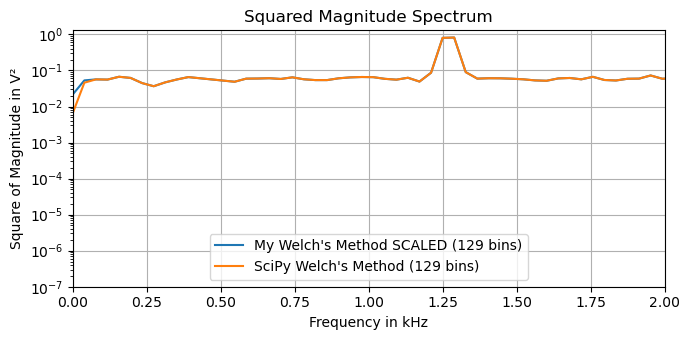

In [8]:
"My Welch Comparison (Toy Signals)"

import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal


def my_welch(wf, fs, scale=True):
    # Define window length
    n_padded_welch = 256
    n_win = 256
    n_shift = int(n_win*0.5)
    num_wins = None

    
    n_possible_win_starts = len(wf) - n_win # Number of samples that could be a start of a sample
    n_full_wins_from_possible_win_starts = np.floor(n_possible_win_starts / n_shift) # Number of full windows we can get out of this set
    max_num_wins = n_full_wins_from_possible_win_starts + 1 # Add one more because the final sample in n_possible_win_starts can always be a sample (though the real start will likely be before this)
    num_wins_final = int(min(num_wins, max_num_wins)) if num_wins is not None else int(max_num_wins) # Use num_wins if provided and valid, otherwise use the maximum number of windows we can get
    
    window = get_window('hann', n_win)
    norm = 2*np.ones((n_padded_welch // 2) + 1) # Multiply by two for real FFT (only using half the frequencies)
    norm[0] = 1  # ...except for the DC and
    norm[-1] = 1 # ...Nyquist frequencies
    norm /= np.sum(window)**2 # Squared sum of window coefficients for window normalization (just N for rectangle)
    
    if scale==False:
        norm = 1
    
    # Divide the waveform into windows of length n_win, take magnitude of FFT of each
    powers_list = [
        norm*np.abs(rfft(np.pad(wf[i*n_shift : i*n_shift + n_win]*window, (0, n_padded_welch-n_win), 'constant')))**2 # Each new window has a start index that's n_shift more than the last
        for i in range(num_wins_final)
    ]

    # Average over all windows
    return rfftfreq(n_padded_welch, 1/fs), np.mean(powers_list, axis=0)
    # return rfftfreq(n_padded, 1/fs), powers_list[0]

rng = np.random.default_rng(73625)  # seeding for reproducibility

fs, n = 10e3, 10_000
f_x, noise_power = 1270, 1e-3 * fs / 2
t = np.arange(n) / fs
x = (np.sqrt(2) * np.sin(2 * np.pi * f_x * t) +
     rng.normal(scale=np.sqrt(noise_power), size=t.shape))

fg, axx = plt.subplots(1, 1, sharex='all', tight_layout=True, figsize=(7, 3.5))
axx.set(title="Squared Magnitude Spectrum", ylabel="Square of Magnitude in V²")
# axx[1].set(title="Power Spectral Density", ylabel="Power Spectral Density in V²/Hz")
f_p, P_p = signal.periodogram(x, fs, 'hann', scaling='spectrum')
f_w_sp, P_w_sp = signal.welch(x, fs, 'hann', scaling='spectrum')
f_w, P_w = my_welch(x, fs)
f_w_unscaled, P_w_unscaled = my_welch(x, fs, scale=False)
# axx.semilogy(f_p/1e3, P_p, label=f"Periodogram ({len(f_p)} bins)")
axx.semilogy(f_w/1e3, P_w, label=f"My Welch's Method SCALED ({len(f_w)} bins)")
# axx.semilogy(f_w_unscaled/1e3, P_w_unscaled, label=f"My Welch's Method UNSCALED ({len(f_w)} bins)")
axx.semilogy(f_w_sp/1e3, P_w_sp, label=f"SciPy Welch's Method ({len(f_w_sp)} bins)")
axx.set(xlabel="Frequency in kHz", xlim=(0, 2), ylim=(1e-7, 1.3))
axx.grid(True)
axx.legend(loc='lower center')

print("Max value in P_w:", np.max(P_w))
print("Index of max value in P_w:", np.argmax(P_w))

print("Max value in P_w_unscaled:", np.max(P_w_unscaled))
print("Index of max value in P_w_unscaled:", np.argmax(P_w_unscaled))

print("Max value in P_w_sp:", np.max(P_w_sp))
print("Index of max value in P_w_sp:", np.argmax(P_w_sp))


plt.show()

In [ ]:
"My Welch Comparison Plots (Experimental)"
f = rfftfreq(32768, 1/44100)

index = 10
wf = df.iloc[index]['wf']
sr = 44100

win_type='hann'
padding = 16

# chris_welch = get_welch_og_chris(wf)
f, my_welch = get_welch(wf, win_type='hann', n_win=32768)
f_higher_res_padded, my_welch_higher_res_padded = get_welch(wf, win_type=win_type, n_win=262144, zero_pad=padding)
f_higher_res, my_welch_higher_res = get_welch(wf, win_type=win_type, n_win=262144)
f_highest_res, my_welch_highest_res = get_welch(wf, win_type=win_type, n_win=524288)
# pg = get_pg(wf, win_type=win_type)
# pg_halved = get_pg(wf[0:len(wf)//2], win_type=win_type)

# plt.plot(f, chris_welch, label='Chris Welch')
plt.plot(f, my_welch, label=f'My Welch', alpha=1)
plt.plot(f_higher_res, my_welch_higher_res, label=f'My Welch (Higher Res)', alpha=1)
plt.plot(f_higher_res_padded, my_welch_higher_res_padded, label=f'My Welch (Higher Res Padded {padding}x)', alpha=0.5)
plt.plot(f_highest_res, my_welch_highest_res, label=f'My Welch (Highest Res)')
# plt.plot(rfftfreq(len(wf), 1/sr), pg, label='Periodogram')
# plt.plot(rfftfreq(len(wf)//2, 1/sr), pg_halved, label='Periodogram (Halved)', alpha=0.5)

plt.xlim(0, 3000)
# plt.ylim(7.5, 15)
plt.title(f"Periodogram Comparison ({win_type})")
plt.legend()
plt.show()


# f_scipy, scipy_welch = get_scipy_welch(wf, win_type=win_type, n_win=32768)
# plt.plot(f_scipy, scipy_welch, label='Scipy Welch', alpha=0.5)
# print(my_welch)
# print(scipy_welch)

In [1]:
"Exploring PS vs PSD with/without Welch, with/without noise"
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, periodogram

# SIGNAL SAMPLING PARAMS
fs = 1000  # Sampling frequency in Hz
t_max = 10 # Signal duration in seconds
N = fs * t_max  # Number of samples
t = np.linspace(0, t_max, N, endpoint=False)  # Time vector

# PERIODOGRAM PARAMS
n_padded_periodogram = N * 1 # Zero padding for periodogram

for n_padded_periodogram_factor in np.arange(1, 10, 1):
    n_padded_periodogram = N * n_padded_periodogram_factor

    # WELCH PARAMS
    n_win = 2**15 # Size of each Welch window
    n_padded_welch = n_win * 8 # Zero padding for Welch window

    # Repeat for mulitple window types
    for window_type in ['boxcar']:

        # Signal parameters
        freq = 100.05  # Frequency of the sinusoid in Hz
        decay_rate = 0 # Exponential decay rate
        A = 5 # Amplitude of the decaying sinusoid
        # Noise paramaters
        noise_power_density = 0 # Power of the noise in Power/Hz
        effective_bandwidth = fs/2 # Effective bandwidth in Hz; AKA the frequency range we use from Nyquist sampling theorem
        total_noise_power = noise_power_density * effective_bandwidth # Total noise power in entire signal. 
        # This is now the variance of the white noise. Since then in the time domain, the total noise power is 1/N * sum((signal - 0)^2)... aka the variance!
        noise = np.random.normal(loc=0, scale=np.sqrt(total_noise_power), size=N)

        # Generate exponentially decaying sinusoid with noise 
        signal = A * np.exp(-decay_rate * t) * np.sin(2 * np.pi * freq * t)
        combined_signal = signal + noise

        # Calculate Power Spectral Density (PSD)
        f_psd, psd = periodogram(combined_signal, fs, window=window_type, nfft=n_padded_periodogram, scaling='density')

        # Calculate Power Spectrum (PS; squared magnitude of FFT)
        f_ps, ps = periodogram(combined_signal, fs, window=window_type, nfft=n_padded_periodogram, scaling='spectrum')

        # Calculate Power Spectral Density (PSD) using Welch's method
        f_psd_welch, psd_welch = welch(combined_signal, fs, nperseg=n_win, nfft=n_padded_welch, window=window_type, scaling='density')

        # Calculate Power Spectrum (PS; squared magnitude of FFT) using Welch's method
        f_ps_welch, ps_welch = welch(combined_signal, fs, nperseg=n_win, nfft=n_padded_welch, window=window_type, scaling='spectrum')

        # Frequency bin width (delta f) for PSD
        delta_f = f_psd[1] - f_psd[0]
        delta_f_welch = f_psd_welch[1] - f_psd_welch[0]

        # Find indices for the frequency range
        f_hw = 0.1
        f_min = np.round(freq - f_hw, 2)  # Minimum frequency in Hz
        f_max = np.round(freq + f_hw, 2) # Maximum frequency in Hz

        # Find indices where the frequencies are between 50 and 150 Hz
        ps_welch_indices = np.where((f_ps_welch >= f_min) & (f_ps_welch <= f_max))
        psd_welch_indices = np.where((f_psd_welch >= f_min) & (f_psd_welch <= f_max))
        ps_indices = np.where((f_ps >= f_min) & (f_ps <= f_max))
        psd_indices = np.where((f_psd >= f_min) & (f_psd <= f_max))

        # Total power from PSD (sum over all bins, multiplying by delta f)
        total_power_psd = np.sum(psd[psd_indices] * delta_f)
        total_power_psd_welch = np.sum(psd_welch[psd_welch_indices] * delta_f_welch)

        # Total power from Power Spectrum (sum over frequency range)
        total_power_spectrum = np.sum(ps[ps_indices])
        total_power_spectrum_welch = np.sum(ps_welch[ps_welch_indices])
        # Calculate average power in the time domain
        combined_average_power_time_domain = np.mean(combined_signal**2)
        signal_average_power_time_domain = np.mean(signal**2)
        noise_average_power_time_domain = np.mean(noise**2)
        noise_avg_start = np.argmin(np.abs(f_psd - 300))
        noise_avg_start_welch = np.argmin(np.abs(f_psd_welch - 300))
        noise_in_frequency_domain_periodogram = np.round(np.mean(psd[noise_avg_start:-1]), 3)
        noise_in_frequency_domain_welch = np.round(np.mean(psd_welch[noise_avg_start_welch:-1]), 3)


        # Print the result
        print("Window type:", window_type)
        print("Bin width = ", 1/t_max, "Hz")
        print("Center Frequency = ", freq, "Hz")
        print("True noise power / Hz = ", noise_power_density)
        print("True total noise power: ", total_noise_power)
        print("TIME DOMAIN:")
        print(f"Average power of pure signal: {signal_average_power_time_domain:.2f}")
        print(f"Average power of pure noise: {noise_average_power_time_domain:.2f}")
        print(f"Average power of combined: {combined_average_power_time_domain:.2f}")
        print("")
        print("PSD: Scale by 2/(N*binwidth*sum(window^2))")
        print(f"To get power from PSD, we add up density at each bin * bin width over frequency range of interest {f_min}-{f_max}Hz")
        print(f"Periodogram: {total_power_psd:.2f}")
        print(f"Welch: {total_power_psd_welch:.2f}")
        print("Noise power estimates:")
        print("Periodogram: ", noise_in_frequency_domain_periodogram)
        print("Welch: ", noise_in_frequency_domain_welch)
        print("")
        print("PS: Scale by 2/(sum(window)^2)")
        print(f"Power over {f_min}-{f_max}Hz from PS")
        print("Not how PS is supposed to be used! But sometimes accurate, if noise is low and parameters are such that there is just a single bin of peak.")
        print(f"Periodogram: {total_power_spectrum:.2f}")
        print(f"Welch      : {total_power_spectrum_welch:.2f}")
        # The PS height of a spur gives the predicted average power from that sinusoid. This is equivalent to the RMS amplitude, squared.
        # For a sinusoidal signal Asin(ωt), the RMS amplitude is 𝐴 / sqrt(2).
        # So the PS will give an estimate for A^2 / 2 
        print("")
        print("PS spur *heights* actually give correct estimates, but you have to be careful of scallopping loss.")
        print("This can be mitigated by:")
        print("1. Zero padding to make sure we sample the DTFT at the true spur peak")
        print("2. Different window functions (though zero padding seems more effective for this!)")
        print("")
        print(f"Periodogram height of Peak (correct estimate for average power): {np.max(ps):.2f}")
        print(f"Welch       height of Peak (correct estimate for average power): {np.max(ps_welch):.2f}")
        print(f"Periodogram Estimate for 'A' (Average Power is A^2 / 2): {np.sqrt(2 * np.max(ps)):.2f} vs True 'A': {A}")
        print(f"Welch       Estimate for 'A' (Average Power is A^2 / 2): {np.sqrt(2 * np.max(ps_welch)):.2f} vs True 'A': {A}")

        # print()

        # # Plot results
        # plt.figure(figsize=(12, 6))

        # # Plot PSD (linear scale)
        # plt.subplot(1, 2, 1)
        # plt.plot(f_psd, psd, label='Periodogram')
        # # plt.plot(f_psd_welch, psd_welch, label='Welch')
        # plt.title('Power Spectral Density (PSD)')
        # plt.xlabel('Frequency (Hz)')
        # plt.ylabel('Power (linear)')
        # plt.xlim(f_min, f_max)
        # plt.legend()

        # # Plot Power Spectrum (linear scale)
        # plt.subplot(1, 2, 2)
        # plt.plot(f_ps, ps, label='Periodogram')
        # # plt.plot(f_ps_welch, ps_welch, label='Welch')
        # plt.title('Power Spectrum')
        # plt.xlabel('Frequency (Hz)')
        # plt.ylabel('Power (linear)')
        # plt.xlim(f_min, f_max)
        # plt.legend()

        # plt.tight_layout()
        # plt.show()




c:\ProgramData\miniconda3\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 32768 is greater than input length  = 10000, using nperseg = 10000
  warnings.warn('nperseg = {0:d} is greater than input length '


Window type: boxcar
Bin width =  0.1 Hz
Center Frequency =  100.05 Hz
True noise power / Hz =  0
True total noise power:  0.0
TIME DOMAIN:
Average power of pure signal: 12.50
Average power of pure noise: 0.00
Average power of combined: 12.50

PSD: Scale by 2/(N*binwidth*sum(window^2))
To get power from PSD, we add up density at each bin * bin width over frequency range of interest 99.95-100.15Hz
Periodogram: 10.13
Welch: 11.29
Noise power estimates:
Periodogram:  0.0
Welch:  0.0

PS: Scale by 2/(sum(window)^2)
Power over 99.95-100.15Hz from PS
Not how PS is supposed to be used! But sometimes accurate, if noise is low and parameters are such that there is just a single bin of peak.
Periodogram: 10.13
Welch      : 295.84

PS spur *heights* actually give correct estimates, but you have to be careful of scallopping loss.
This can be mitigated by:
1. Zero padding to make sure we sample the DTFT at the true spur peak
2. Different window functions (though zero padding seems more effective for

In [ ]:
"Magnitude and phase Hann and Boxcar windows"

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window
from scipy.fft import fft, fftfreq

# Parameters
N = 2**14  # Length of the window (2^14 = 16384)
fs = 1000  # Sampling frequency
pad_factor = 10 # Zero-padding factor
N_padded = N * pad_factor

# Generate the windows
hann_window = get_window('hann', N)
boxcar_window = get_window('boxcar', N)

# Zero-padding the windows (adding zeros on either side)
zero_padded_hann = np.pad(hann_window, (0, N_padded - N))  # Pad with zeros to N_padded length
zero_padded_boxcar = np.pad(boxcar_window, (0, N_padded - N))  # Pad with zeros to N_padded length

# Compute the Fourier Transform of the zero-padded windows
hann_ft = fft(zero_padded_hann)
boxcar_ft = fft(zero_padded_boxcar)
hann_mags = np.abs(hann_ft)
boxcar_mags = np.abs(boxcar_ft)
hann_phases = np.angle(hann_ft)
boxcar_phases = np.angle(boxcar_ft)

# Frequency axis (both positive and negative frequencies)
f_window = fftfreq(N_padded, 1/fs)  # Full frequency axis (both negative and positive)

# Plot the magnitude and phase of the Fourier Transforms
plt.figure(figsize=(10, 8))

width = 1  # Frequency range for zooming in

print("S1 (Boxcar) = ", N)
print("S1 (Hann) = ", np.sum(hann_window))
print("Max value in boxcar window mags:", np.max(boxcar_mags))
print("Max value in hann window mags:", np.max(hann_mags))

# Hann window - Magnitude
plt.subplot(2, 2, 1)
plt.scatter(f_window, hann_mags, s=1)
plt.title('Magnitude of Fourier Transform of Hann Window')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(-width, width)

# Boxcar window - Magnitude
plt.subplot(2, 2, 2)
plt.scatter(f_window, boxcar_mags, s=1)
plt.title('Magnitude of Fourier Transform of Boxcar Window')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(-width, width)

# Hann window - Phase
plt.subplot(2, 2, 3)
plt.scatter(f_window, hann_phases, s=1)
plt.title('Phase of Fourier Transform of Hann Window')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (radians)')
plt.xlim(-width, width)

# Boxcar window - Phase
plt.subplot(2, 2, 4)
plt.scatter(f_window, boxcar_phases, s=1)
plt.title('Phase of Fourier Transform of Boxcar Window')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (radians)')
plt.xlim(-width, width)

# Adjust spacing between subplots
plt.tight_layout(pad=3.0)

plt.show()



In [ ]:
"Proof that noise 'adds' to the signal at the relevant frequency"
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift

amps = []

# Parameters
fs = 1000  # Sampling frequency in Hz
T = 1  # Duration of the sine wave in seconds
f0 = 50  # Frequency of the sine wave in Hz
N = fs * T  # Number of samples
padding_factor = 8 # Zero-padding factor
sigma_noise = 10
N_padded = N * padding_factor

n_averages = 10000

for i in range(n_averages): 

    hann_window = get_window('hann', N)

    # Generate the time axis
    t = np.linspace(0, T, int(N), endpoint=False)

    # Generate a pure sine wave
    sine_wave = np.cos(2 * np.pi * f0 * t)

    # Add noise to the sine wave
    noise = np.random.normal(0, sigma_noise, N)
    sine_wave_with_noise = sine_wave + noise

    # Zero-padding the sine wave
    zero_padded_sine = np.pad(sine_wave_with_noise, (0, N_padded - len(sine_wave)))

    # Compute the Fourier Transform of the sine wave
    sine_ft = 2 * rfft(zero_padded_sine) / N
    sine_mags = np.abs(sine_ft)
    sine_phases = np.angle(sine_ft)

    # Frequency axis (shifted so that zero is at the center)
    f = rfftfreq(N_padded, 1/fs)

    f0_index = np.argmin(np.abs(f - f0))

    print(sine_mags[f0_index])
    amps.append(sine_mags[f0_index])

    plot = False

    if plot:

        # Plot the magnitude and phase of the Fourier Transform
        plt.figure(figsize=(10, 8))

        # Plot magnitude
        plt.subplot(2, 2, 1)
        plt.scatter(f, sine_mags, s=1)
        plt.title('Magnitude of Fourier Transform of Sine Wave')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.xlim(f0 - 10, f0 + 10)

        # Plot phase
        plt.subplot(2, 2, 2)
        plt.scatter(f, sine_phases, s=1)
        plt.title('Phase of Fourier Transform of Sine Wave')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Phase (radians)')
        plt.xlim(f0 - 1, f0 + 1)

        # Adjust spacing between subplots
        plt.tight_layout(pad=3.0)

        plt.show()
        
print("Amps mean = ", np.mean(amps))
    



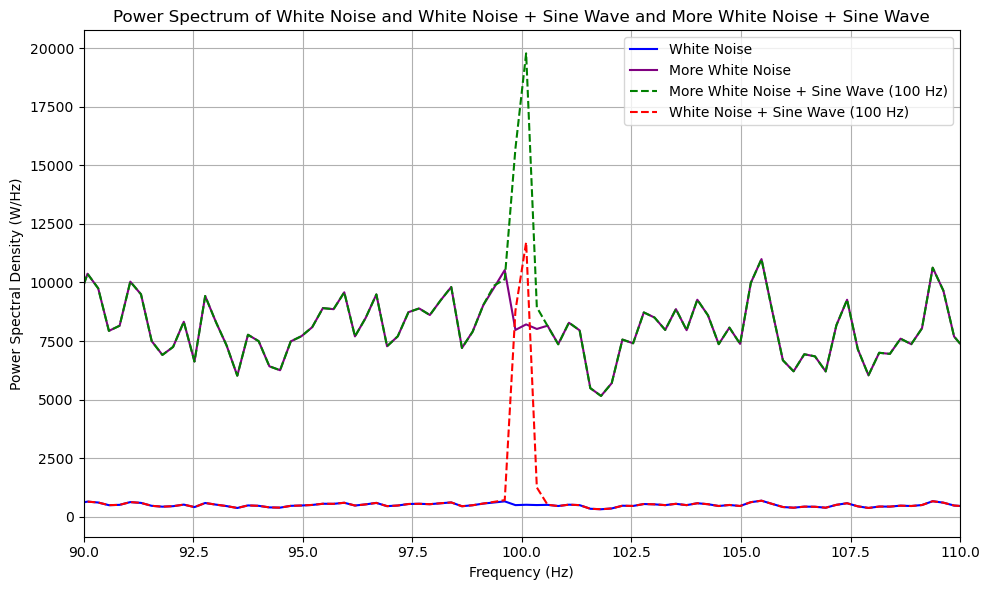

Power Spectrum at 100 Hz for White Noise: 513.221105 W/Hz
Power Spectrum at 100 Hz for White Noise + Sine Wave: 11717.850691 W/Hz
Power Spectrum at 100 Hz for Sine Wave: 11083.400943 W/Hz
Difference in Power Spectrum at 100 Hz (White Noise + Sine Wave - White Noise): 11204.629587 W/Hz


In [2]:
"Exploring noise and signal addition"

# Parameters
fs = 1000  # Sampling frequency (Hz)
duration = 100  # Duration of the signal (seconds)
n_samples = fs * duration  # Total number of samples
f_sine = 100  # Frequency of the sine wave (Hz)
noise_amp = 500
more_noise_amp = 2000
sine_amp = 100
window = 'hann'

# Generate white noise
base_noise = np.random.normal(0, 1, n_samples)
white_noise = noise_amp * base_noise
more_white_noise = more_noise_amp * base_noise

# Generate a sine wave at 100 Hz
t = np.arange(n_samples) / fs  # Time vector
sine_wave = sine_amp * np.sin(2 * np.pi * f_sine * t)

# Add the sine wave to the white noise
signal_with_sine = white_noise + sine_wave
more_white_noise_with_sine = more_white_noise + sine_wave

# Compute the Power Spectral Density (PSD) of the white noise
f_white_noise, Pxx_white_noise = welch(white_noise, fs, window=window, nperseg=4096)

# Compute the Power Spectral Density (PSD) of the more white noise
f_more_white_noise, Pxx_more_white_noise = welch(more_white_noise, fs, window=window, nperseg=4096)

# Compute the Power Spectral Density (PSD) of the signal with the sine wave
f_signal, Pxx_signal = welch(signal_with_sine, fs, window=window, nperseg=4096)

# Compute the Power Spectral Density (PSD) of the signal with the sine wave
f_signal_more_noise, Pxx_signal_more_noise = welch(more_white_noise_with_sine, fs, window=window, nperseg=4096)

# Compute the Power Spectral Density (PSD) of the sine wave
f_sine_wave, Pxx_sine_wave = welch(sine_wave, fs, window=window, nperseg=4096)

# Plot both power spectra (White Noise and White Noise + Sine Wave) on the same plot
plt.figure(figsize=(10, 6))

plt.plot(f_white_noise, Pxx_white_noise, label='White Noise', color='b')
plt.plot(f_more_white_noise, Pxx_more_white_noise, label='More White Noise', color='purple')
plt.plot(f_signal_more_noise, Pxx_signal_more_noise, label='More White Noise + Sine Wave (100 Hz)', color='g', linestyle='--')
plt.plot(f_signal, Pxx_signal, label='White Noise + Sine Wave (100 Hz)', color='r', linestyle='--')

plt.title('Power Spectrum of White Noise and White Noise + Sine Wave and More White Noise + Sine Wave')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (W/Hz)')
plt.xlim(90, 110)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# # Plot the power spectrum of just the sine wave
# plt.figure(figsize=(10, 6))
# plt.plot(f_sine_wave, Pxx_sine_wave, label='Sine Wave at 100 Hz', color='g')
# plt.title('Power Spectrum of Sine Wave at 100 Hz')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Power Spectral Density (W/Hz)')
# plt.xlim(90, 110)
# plt.legend()
# plt.grid()

# plt.tight_layout()
# plt.show()

# Find the index closest to 100 Hz in the frequency arrays
index_100Hz_signal = np.argmin(np.abs(f_signal - f_sine))
index_100Hz_white_noise = np.argmin(np.abs(f_white_noise - f_sine))
index_100Hz_sine_wave = np.argmin(np.abs(f_sine_wave - f_sine))

# Get the power spectral densities at 100 Hz for both signals
Pxx_white_noise_100Hz = Pxx_white_noise[index_100Hz_white_noise]
Pxx_signal_100Hz = Pxx_signal[index_100Hz_signal]
Pxx_sine_wave_100Hz = Pxx_sine_wave[index_100Hz_sine_wave]

# Compute the difference between the two spectra at 100 Hz
difference_at_100Hz = Pxx_signal_100Hz - Pxx_white_noise_100Hz

# Print the power at {f_sine} Hz for each spectrum and the difference
print(f"Power Spectrum at {f_sine} Hz for White Noise: {Pxx_white_noise_100Hz:.6f} W/Hz")
print(f"Power Spectrum at {f_sine} Hz for White Noise + Sine Wave: {Pxx_signal_100Hz:.6f} W/Hz")
print(f"Power Spectrum at {f_sine} Hz for Sine Wave: {Pxx_sine_wave_100Hz:.6f} W/Hz")
print(f"Difference in Power Spectrum at 100 Hz (White Noise + Sine Wave - White Noise): {difference_at_100Hz:.6f} W/Hz")

In [ ]:
# Plotting function for PS / PSD Comparisons
def plot_spectrum_ps_psd(wf, scaling, win_type, nperseg, nfft, detrend=False, db=True, zorder=1, fs=44100, ow_label=None):
    f, spec = welch(wf, scaling=scaling, fs=fs, window=win_type, nperseg=nperseg, nfft=nfft, detrend=detrend)
    
    if scaling == 'spectrum':
        label = "Power Spectrum"
        ylabel = "PS"
    elif scaling == 'density':
        label = "Power Spectral Density"
        ylabel = "PSD"
        
    if db:
        # Convert to dB
        spec = 10 * np.log10(spec)
        ylabel += " (dB)"
    else:
        ylabel += " (Linear)"
    
    if detrend == "constant":
        label += " (Detrended)"
    elif detrend == False:
        label += " (Not Detrended)"
        
    label+=f": nperseg={nperseg}"
    
    if ow_label is not None:
        label = ow_label

    plt.plot(f, spec, label=label, zorder=zorder)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel(ylabel)
    plt.legend()
    
    return f, spec

"PSD Toy Noise Effect"
# SIGNAL SAMPLING PARAMS
fs = 1000  # Sampling frequency in Hz
t_max = 100000 # Signal duration in seconds (bin width is 1/t_max)
N = fs * t_max  # Number of samples
t = np.linspace(0, t_max, N, endpoint=False)  # Time vector
nperseg = 32768
nfft = nperseg*1

# Signal parameters
freq = 100  # Frequency of the sinusoid in Hz
decay_rate = 0 # Exponential decay rate
A = 10 # Amplitude of the decaying sinusoid
# Noise parameters
noise_power_density = 0 # Power of the noise in Power/Hz


plt.figure(figsize=(15, 10))
plt.title("Toy Sinusoid PSD: Noise Raises Floor")
n_averages = 1
PDs = np.zeros((3, n_averages))
for i, noise_power_density in enumerate([0, 10, 20]):
    for j in range(n_averages):
        effective_bandwidth = fs/2 # Effective bandwidth in Hz; AKA the frequency range we use from Nyquist sampling theorem
        total_noise_power = noise_power_density * effective_bandwidth # Total noise power in entire signal. 
        # This is now the variance of the white noise. Since then in the time domain, the total noise power is 1/N * sum((signal - 0)^2)... aka the variance!
        noise = np.random.normal(loc=0, scale=np.sqrt(total_noise_power), size=N)

        wf_toy = A * np.exp(-decay_rate * t) * np.sin(2 * np.pi * freq * t) + noise
        f, spec = plot_spectrum_ps_psd(wf_toy, "density", "boxcar", nperseg, nfft, detrend=False, db=False, zorder=int(100/(i+1)), fs=fs, ow_label=f"NPD = {noise_power_density}")
        
        idx = np.argmin(np.abs(f - freq))
        PDs[i][j] = spec[idx]
    print(f"Average 100Hz PD with NPD = {noise_power_density:.2f}: {np.mean(PDs[i])}")
        
fmin = freq - 10
fmax = freq + 10
plt.xlim(fmin, fmax)
plt.ylim(1000, 1100)

plt.show()